In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# !ls "/content/gdrive/My Drive"

In [0]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## basic parameters

## draw trajectory function

In [0]:
class Point(object):
    
    def __init__(self, lat, lon, rpixel, cpixel):
        self.lat = lat
        self.lon = lon
        self.rpixel = rpixel
        self.cpixel = cpixel
    
    def get_coord(self):
        return np.array([self.lat, self.lon])
    
    def get_pixel(self):
        return np.array([self.rpixel, self.cpixel])

    
class coord_pixel_transform(object):
    """ the order : row first, col second """
    
    def __init__(self, resolution, pntC, pntR):
        self.resolution = resolution
        self.pnt_one = pntC
        self.pnt_two = pntR
        self.left_top = np.array([0, 0])
        self.right_top = np.array([0, 0])
        self.left_bottom = np.array([0, 0])
        self.right_bottom = np.array([0, 0])
        
        delta_coord = self.pnt_one.get_coord() - self.pnt_two.get_coord()
        delta_pixel = self.pnt_one.get_pixel() - self.pnt_two.get_pixel()
        self.delta = np.absolute(delta_coord) / np.absolute(delta_pixel) 
    
    def print_delta(self):
        print(self.delta)
        
    def get_left_top(self):
        pnt_lat = self.pnt_one.get_coord()[0]
        pnt_lon = self.pnt_one.get_coord()[1]
        pnt_xpix = self.pnt_one.get_pixel()[0]
        pnt_ypix = self.pnt_one.get_pixel()[1]
        
        lat1 = pnt_lat + self.delta[0] * pnt_ypix
        lon1 = pnt_lon - self.delta[1] * pnt_xpix
        self.left_top = np.array([lat1, lon1])

    def map_AABB_coords(self):
        lat2 = self.left_top[0] - self.resolution[0] * self.delta[0]
        lon2 = self.left_top[1]
        self.left_bottom = np.array([lat2, lon2])
        print("LEFT-BOTTOM: lat, lon: ", self.left_bottom) 
        
        lat3 = self.left_top[0]
        lon3 = self.left_top[1] + self.resolution[1] * self.delta[1]
        self.right_top = np.array([lat3, lon3])
        print("RIGHT-TOP: lat, lon: ", self.right_top) 
        
        lat4 = self.left_top[0] - self.resolution[0] * self.delta[0]
        lon4 = self.left_top[1] + self.resolution[1] * self.delta[1]
        self.right_bottom = np.array([lat4, lon4])
        print("RIGHT-TOP: lat, lon: ", self.right_bottom) 
        
    """ np_pnt = [row, col] """
    def pixel_to_coord(self, np_pnt):
        self.get_left_top()
        lat = self.left_top[0] - np_pnt[0] * self.delta[0]
        lon = self.left_top[1] + np_pnt[1] * self.delta[1]
        coord = np.array([lat, lon])
        return coord
        print("RIGHT-TOP: lat, lon: ", self.right_bottom) 
    
    def coord_to_pixel(self, lat, lon):        
        self.get_left_top()
        lat_diff = self.left_top[0] - lat
        row_idx = lat_diff / self.delta[0]
        
        lon_diff = lon - self.left_top[1]
        col_idx = lon_diff / self.delta[1]
        
        return row_idx.astype(int), col_idx.astype(int)
        
        


In [0]:
""" [rows, cols] """
resolution = np.array([3300, 3300])
""" lat, lon, y, x """
pnt_R = Point(42.34662, -71.00773, 1187, 3223)
pnt_C = Point(42.324509, -71.109540, 1650, 1650)

transform = coord_pixel_transform(resolution, pnt_C, pnt_R)

## Draw trajectories on map all at once




In [0]:
trajs_file = '/content/gdrive/My Drive/00-colab-code/trajectory/gis-trajs-tims.csv'
trajs = pd.read_csv(trajs_file, delimiter='\t')
idx = trajs.index[trajs['traj_id'] == 1].tolist()

lat_list = trajs['lat_start'][idx]
lon_list = trajs['lon_start'][idx]

y_rows, x_cols = transform.coord_to_pixel(lat_list, lon_list)

In [0]:
img = '/content/gdrive/My Drive/00-colab-code/trajectory/map.png'
img = plt.imread(img)
imgplot = plt.imshow(img)    
    
plt.plot(x_cols, y_rows)
imgplot.axes.grid(False)

## Draw trajectories on map iteratively

In [0]:
def check_distance(lat, lon):
    distance_delta = 0.004
    
    if abs(max(lat) - min(lat)) < distance_delta and \
        abs(max(lon) - min(lon)) <  distance_delta:
        return True
    
    
    
def check_time(time):
    # 15 minites threshold for seperating one trajectory
    time_delta = 0.2
    
    if time <= time_delta:
        return True

## Image showing

`this code can be adjusted to any map mapping`

the total number of trajs:  144


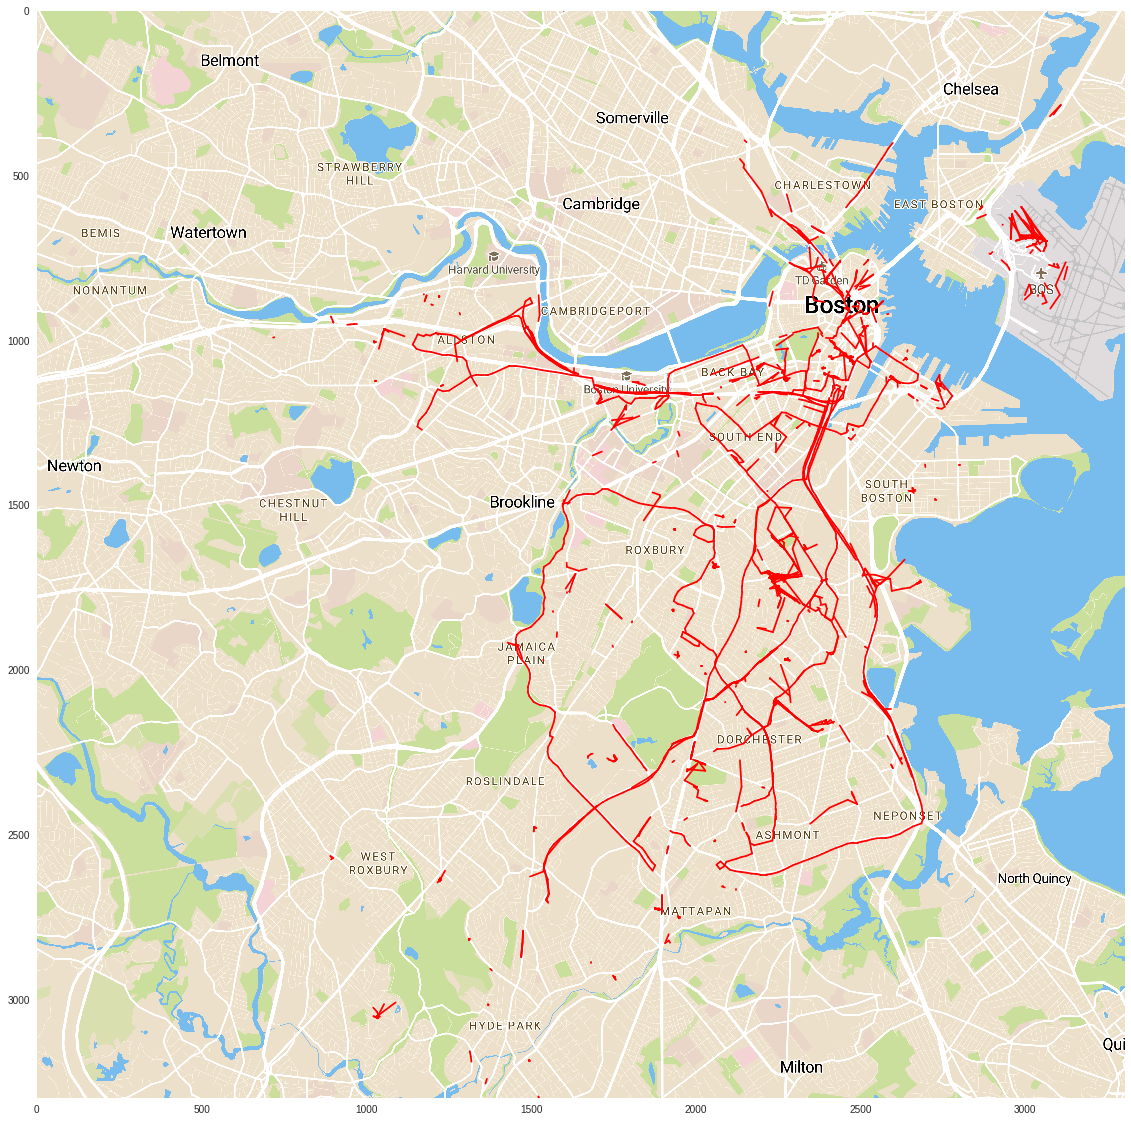

In [38]:

""" [rows, cols] """
resolution = np.array([3300, 3300])
""" lat, lon, y, x """
pnt_R = Point(42.34662, -71.00773, 1187, 3223)
pnt_C = Point(42.324509, -71.109540, 1650, 1650)
transform = coord_pixel_transform(resolution, pnt_C, pnt_R)


trajs_file = '/content/gdrive/My Drive/00-colab-code/trajectory/gis-trajs-tims.csv'

num_trajs = max(trajs['traj_id'])
# num_trajs = 1
print("the total number of trajs: ", num_trajs)

img = '/content/gdrive/My Drive/00-colab-code/trajectory/map.png'
img = plt.imread(img)
imgplot = plt.imshow(img)

''' loop all trajectory '''
for id in range(num_trajs):

    ''' for each  trajectory'''
    idx = trajs.index[trajs['traj_id'] == id+1].tolist()
    for i in idx:
        time = trajs['time'][i]
        
        ''' time checking '''
        if check_time(time):
            lon = [trajs['lon_start'][i], trajs['lon_end'][i]]
            lat = [trajs['lat_start'][i], trajs['lat_end'][i]]
            
            ''' distance checking '''
            if check_distance(lat, lon):
                x, y = transform.coord_to_pixel(lat, lon)
    #             print(x, y)
                if max(x) < resolution[0] and max(y) < resolution[1]:
                    plt.plot(y, x, 'r')
    




# lat_list = trajs['lat_start'][idx]
# lon_list = trajs['lon_start'][idx]
# rows, cols = transform.coord_to_pixel(lat_list, lon_list)

    
plt.plot(cols, rows)
imgplot.axes.grid(False)